# Decaying Dimerization

$$ \text{S}_1 \to 0 \qquad k = c_1 $$
$$ \text{S}_1 + \text{S}_1 \to \text{S}_2 \qquad k = c_2 $$
$$ \text{S}_2 \to \text{S}_1 + \text{S}_1 \qquad k = c_3 $$
$$ \text{S}_2 \to \text{S}_3 \qquad k = c_4$$

Rathinam et al. 2003

In [1]:
from reactionmodel.model import Species, Reaction, Model
import numpy as np
import pandas as pd

S1 = Species('S1')
S2 = Species('S2')
S3 = Species('S3')

reactions = []
reactions.append(Reaction([S1], [], k='c1'))
reactions.append(Reaction([(S1, 2)], [S2], k='c2'))
reactions.append(Reaction([S2], [(S1, 2)],  k='c3'))
reactions.append(Reaction([S2], [S3],  k='c4'))

m = Model([S1, S2, S3], reactions)

In [2]:
rathinam_parameters = {
    'c1': 1,
    'c2': 10,
    'c3': 1000,
    'c4': 0.1,
}

rathinam_initial = {
    'S1': 400,
    'S2': 798,
    'S3': 0
}

In [3]:
from hybrid.gillespie import GillespieSimulator

s = GillespieSimulator(
    m.get_k(parameters=rathinam_parameters, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
)

Evaluating expression: c1 => 1.0
Evaluating expression: c2 => 10.0
Evaluating expression: c3 => 1000.0
Evaluating expression: c4 => 0.1


In [4]:
result = s.simulate(
    [0, 0.2],
    m.make_initial_condition(rathinam_initial, parameters=rathinam_parameters),
    np.random.default_rng()
)

In [5]:
result.status_counter

Counter({<GillespieStepStatus.stochastic: 1>: 306707,
         <GillespieStepStatus.t_end: 0>: 1})

<Axes: >

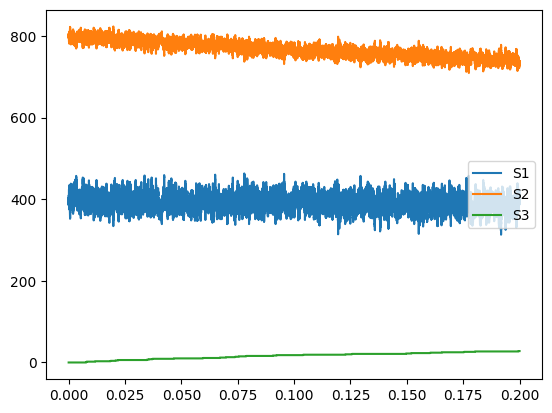

In [6]:
result.plot(m.legend())

In [7]:
from hybrid.tau import TauLeapSimulator

t_s = TauLeapSimulator(
    m.get_k(parameters=rathinam_parameters, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    epsilon=0.08
)

Evaluating expression: c1 => 1.0
Evaluating expression: c2 => 10.0
Evaluating expression: c3 => 1000.0
Evaluating expression: c4 => 0.1


In [8]:
result = t_s.simulate(
    [0, 0.2],
    m.make_initial_condition(rathinam_initial, parameters=rathinam_parameters),
    np.random.default_rng()
)

/Users/thayer/develop/hybrid/hybrid/tau.py:191: RuntimeWarning: invalid value encountered in divide
  tau1 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1) / np.abs(mu_hat_i))
/Users/thayer/develop/hybrid/hybrid/tau.py:192: RuntimeWarning: invalid value encountered in divide
  tau2 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1)**2 / np.abs(sigma_2_hat_i))
/Users/thayer/develop/hybrid/hybrid/tau.py:149: RuntimeWarning: divide by zero encountered in divide
  2 + 1/(y-1),
/Users/thayer/develop/hybrid/hybrid/tau.py:155: RuntimeWarning: divide by zero encountered in divide
  3/2 * (2 + 1/(y-1)),
/Users/thayer/develop/hybrid/hybrid/tau.py:161: RuntimeWarning: divide by zero encountered in divide
  3 + 1/(y-1) + 1/(y-2),
/Users/thayer/develop/hybrid/hybrid/tau.py:191: RuntimeWarning: divide by zero encountered in divide
  tau1 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1) / np.abs(mu_hat_i))
/Users/thayer/develop/hybrid/hybrid/tau.py:192: RuntimeWarning: divide

In [ ]:
tau_df = pd.DataFrame()
t_eval = np.linspace(0., 0.2, 100)
for i in range(500):
    result = t_s.simulate([0.0, 0.2], m.make_initial_condition(rathinam_initial, parameters=rathinam_parameters), np.random.default_rng(), t_eval=t_eval)
    S3 = result.y_history[m.legend().index('S3')]
    r = pd.Series(data=S3, index=result.t_history)
    r = r[t_eval]
    assert(len(r) == len(t_eval))
    r.name = f'_r{i}'
    tau_df = pd.concat([tau_df, r], axis=1)

(0.0, 35.0)

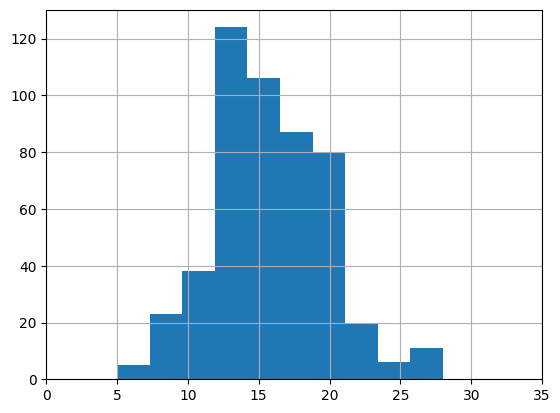

In [27]:
ax = tau_df.iloc[-1].hist()
ax.set_xlim([0.0, 35.0])

# compare with Rathinam figure 5

In [28]:
result.status_counter

Counter({<TauStepStatus.leap: 0>: 5050,
         <TauStepStatus.gillespie_stochastic: 3>: 13,
         <TauStepStatus.rejected_for_gillespie: -2>: 1,
         <TauStepStatus.gillespie_t_end: 2>: 1})

<Axes: >

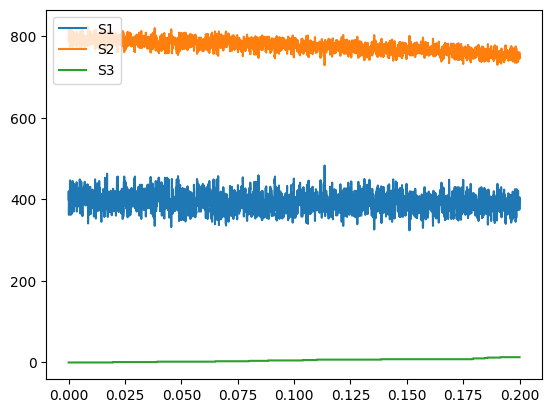

In [11]:
result.plot(m.legend())

In [12]:
print(result.t_history[:5])
result.y_history[:, :5]

[0.00000000e+00 3.99974312e-05 8.21986836e-05 1.19424031e-04
 1.54971587e-04]


array([[400., 420., 376., 362., 380.],
       [798., 788., 810., 817., 808.],
       [  0.,   0.,   0.,   0.,   0.]])

## Haseltine Rawlings

In [13]:
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner

h_s = HybridSimulator(
    m.get_k(parameters=rathinam_parameters, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    partition_function=FixedThresholdPartitioner(100.0)
)

Evaluating expression: c1 => 1.0
Evaluating expression: c2 => 10.0
Evaluating expression: c3 => 1000.0
Evaluating expression: c4 => 0.1


In [14]:
result = h_s.simulate(
    [0, 0.2],
    m.make_initial_condition(rathinam_initial, parameters=rathinam_parameters),
    np.random.default_rng()
)

<Axes: >

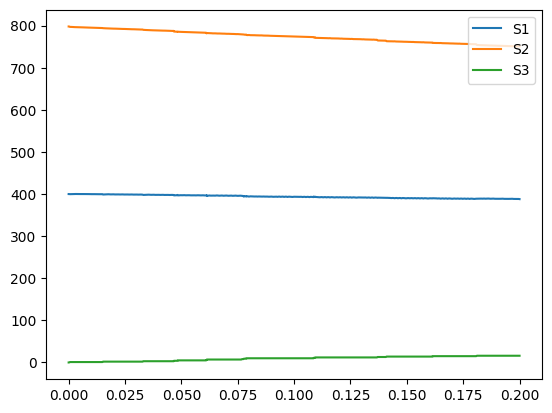

In [15]:
result.plot(m.legend())